<a href="https://colab.research.google.com/github/KOZlegend/Astronomy-1221/blob/Exoplanets/Copy_of_Exoplanet_Transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii

In [114]:
from google.colab import files
uploaded = files.upload()

Saving GJ 436b.txt to GJ 436b.txt


In [118]:
# http://var2.astro.cz/EN/tresca/transit-detail.php?id=1535045428
dat = astropy.io.ascii.read("GJ 436b.txt")

In [119]:
print(dat)

      col1         col2         col3     col4
--------------- ---------- ------------- ----
2454280.6858131 0.99858714 0.00063954038    1
2454280.6861306 0.99893544 0.00064456337    1
2454280.6864482  1.0005495 0.00063337557    1
2454280.6867663  0.9992087 0.00063912305    1
2454280.6870839  0.9999951 0.00063884381    1
2454280.6873985 0.99963366 0.00063370269    1
2454280.6877158 0.99984715 0.00063376504    1
2454280.6880337 0.99940892 0.00063389163    1
2454280.6883513  1.0007346  0.0006491736    1
2454280.6886686  1.0005559 0.00063348365    1
            ...        ...           ...  ...
2454280.8234494  1.0001274 0.00063319333    1
2454280.8237639  1.0007235 0.00063297558    1
2454280.8240813  0.9999841 0.00063839395    1
2454280.8243994  1.0000403 0.00064368427    1
2454280.8247179  1.0002589 0.00064359137    1
2454280.8250325 0.99969261 0.00063327642    1
2454280.8253495 0.99854698 0.00063377299    1
2454280.8256672  1.0007293 0.00063813028    1
 2454280.825985  1.0002464  0.0006

Text(0, 0.5, 'Normalize Flux')

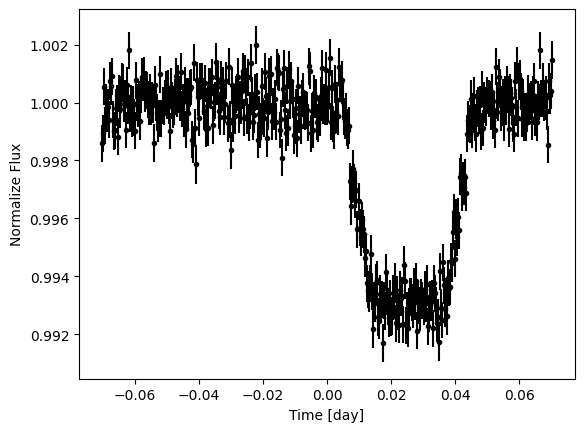

In [121]:
time = dat["col1"] - np.median(dat["col1"])
# rel_mag = dat["col2"]
# flux = 2.514**(1.0 - rel_mag)
flux = dat["col2"]
err = dat["col3"]
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")

In [122]:
def box_model(t, center_time, duration, depth, delta_flux): # model of box based on several parameters
  f = np.zeros(np.shape(t)) # shape of the box based on function of t
  ind = np.where(np.abs(t - center_time) < (duration / 2.0)) # define range of indices where you want to assign values
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0))
  f[ind] = 1.0 + delta_flux
  return(f)

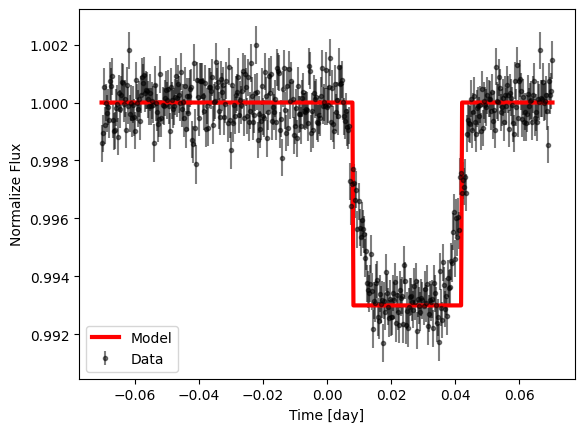

In [154]:
center_time, duration, depth, delta_flux = 0.025, 0.034, 0.007, 0.0 # define parameters
model = box_model(time, center_time, duration, depth, delta_flux) # model box based on parameters
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data") # plot error bars
plt.plot(time, model, color="red", linewidth=3.0, label="Model") # plot box
plt.xlabel("Time [day]") # label x-axis
plt.ylabel("Normalize Flux") # label y-axis
plt.legend();

In [152]:
def calc_reduced_Chi2(O, C, err, n, m): # calculate reduced Chi-Squared
  Chi2 = np.sum(((O - C) ** 2) / (err ** 2))
  reduced_Chi2 = Chi2 / (n - m)
  return(reduced_Chi2)

In [156]:
print(calc_reduced_Chi2(flux, model, err, len(time), 4.0))

2.6830076525121305


In [ ]:
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux = theta
    model = box_model(time, center_time, duration, depth, delta_flux)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
def log_prior(theta):
    center_time, duration, depth, delta_flux = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 and -0.1 < delta_flux < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [ ]:
! pip install -U emcee


In [ ]:
import emcee

pos = np.array([0.0, 0.1, 0.02, 0.0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 10000, progress=True);


100%|██████████| 10000/10000 [02:32<00:00, 65.45it/s]


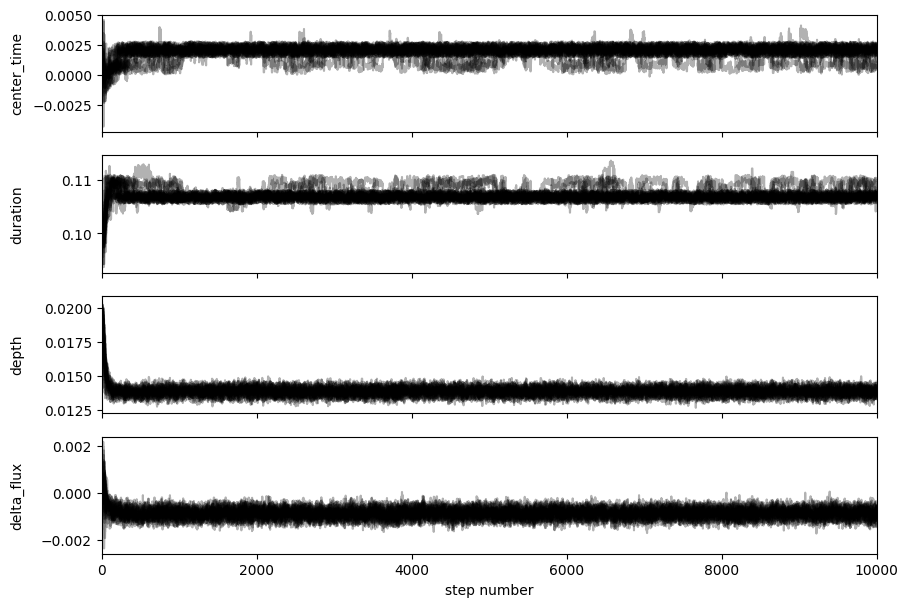

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(6336, 4)


In [ ]:
! pip install corner


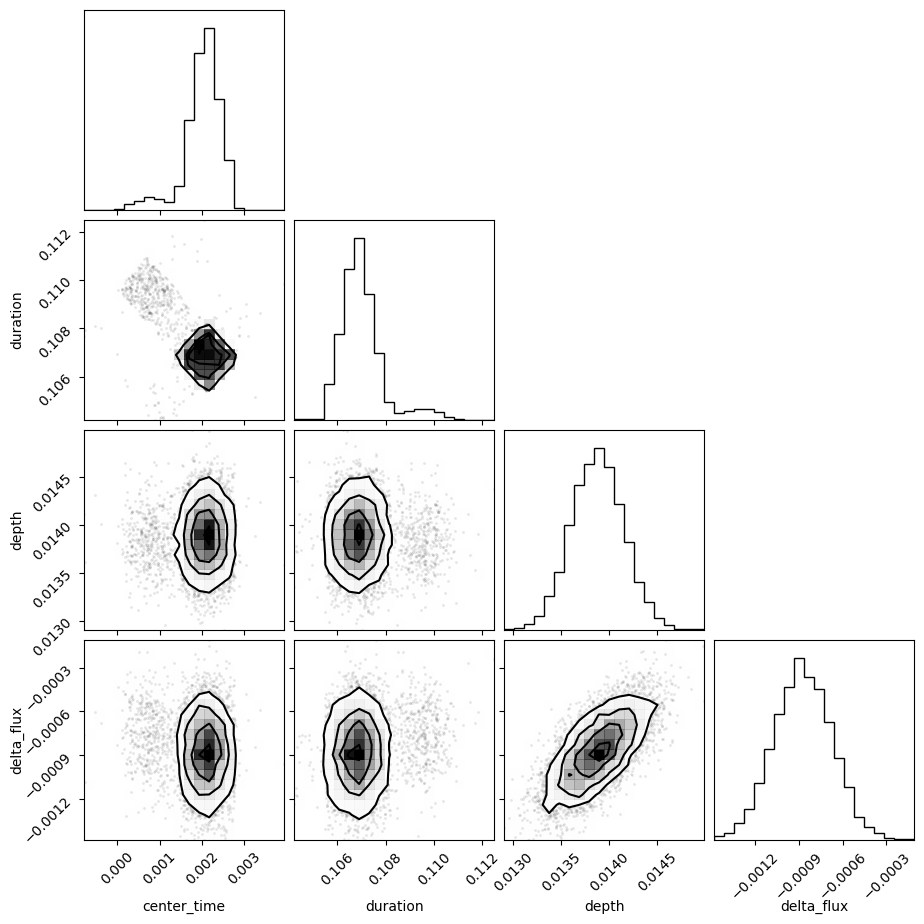

In [ ]:
import corner
fig = corner.corner(flat_samples, labels=labels);

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    center_time, duration, depth, delta_flux = sample
    plt.plot(time, box_model(time, center_time, duration, depth, delta_flux), color="red", alpha=0.1)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.legend(fontsize=14)
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux");


In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

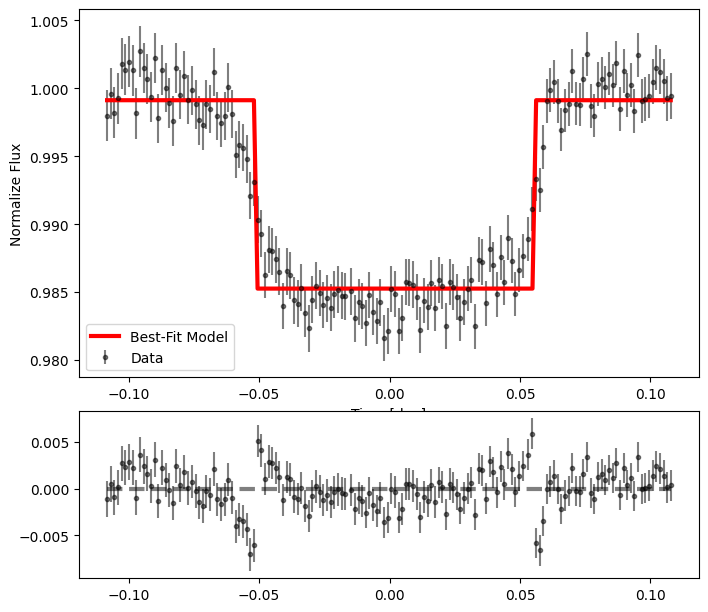

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux = np.percentile(flat_samples, 50, axis=0)
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [ ]:
def calculate_reduced_Chi2(flux, model, err, num_parameters):
  degree_freedom = len(flux) - num_parameters
  rChi2 = np.sum((flux - model)**2 / err**2) / degree_freedom
  return(rChi2)

In [ ]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 4))

Reduced Chi2 =  1.6071865719680467


In [137]:
def trapezoid_model(t, center_time, duration, depth, delta_flux, ingress): # define trapezoidal model
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0 + ingress))
  f[ind] = 1.0 + delta_flux
  ind = np.where((np.abs(t - center_time) <= (duration / 2.0 + ingress)) & (np.abs(t - center_time) > (duration / 2.0)))
  for i in ind[0]:
    delta_t = np.abs(np.abs(t[i] - center_time) - (duration / 2.0))
    f[i] = depth / ingress * delta_t + 1.0 + delta_flux - depth
  return(f)

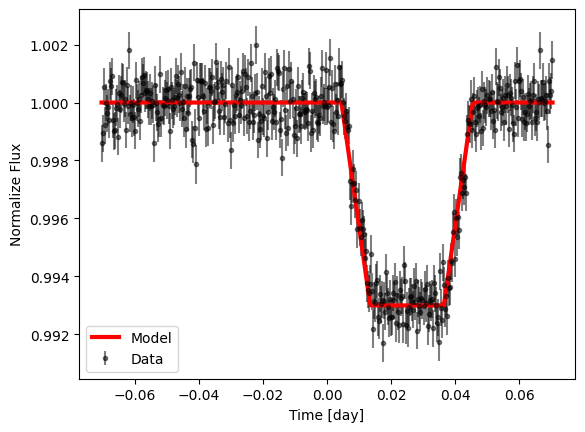

In [160]:
center_time, duration, depth, delta_flux, ingress = 0.025, 0.023, 0.007, 0.0, 0.009 # parameters for trapezoidal model
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [149]:
def calc_reduced_Chi2(O, C, err, n, m): # calculate reduced Chi-Squared
  Chi2 = np.sum(((O - C) ** 2) / (err ** 2))
  reduced_Chi2 = Chi2 / (n - m)
  return(reduced_Chi2)

In [161]:
print(calc_reduced_Chi2(flux, model, err, len(time), 4.0))

1.1115415470155916


In [ ]:
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux, ingress = theta
    model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    center_time, duration, depth, delta_flux, ingress = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 \
      and -0.1 < delta_flux < 0.1 and 0.0 < ingress < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
import emcee

pos = np.array([0.0, 0.1, 0.02, 0.0, 0.025]) + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

 11%|█▏        | 570/5000 [00:12<01:26, 51.22it/s]

In [ ]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux", "ingress"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels);

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux, ingress = np.percentile(flat_samples, 50, axis=0)
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [ ]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 5))